<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Тема 3. Задача классификации, дерево решений и метод ближайших соседей</center>

В первых двух частях мы попрактиковались в первичном анализе данных с Pandas и в построении картинок, позволяющих делать выводы по данным. Сегодня наконец перейдем к машинному обучению. 

<habracut/>

Наверно хочется сразу рвануть в бой, но сначала поговорим про то, какую именно задачу будем решать и каково ее место в области машинного обучения.
Классическое, общее (и не больно то строгое) определение машинного обучения звучит так (T. Mitchell "Machine learning", 1997): "говорят, что компьютерная программа *обучается* при решении какой-то задачи из класса *T*, если ее производительность, согласно метрике *P*, улучшается  при накоплении опыта *E*".

Далее в разных сценариях под *T, P*,  и *E* подразумеваются совершенно разные вещи. Среди самых популярных задач *T* в машинном обучении:
 - классификация – отнесение объекта к одной из категорий на основании его признаков 
 - регрессия – прогнозирование количественного признака объекта на основании прочих его признаков 
 - кластеризация – разбиение множества объектов на группы на основании признаков этих объектов так, чтобы внутри групп объекты были похожи между собой, а вне одной группы  – менее похожи
 - детекция аномалий – поиск объектов, "сильно непохожих" на все остальные в выборке либо на какую-то группу объектов
 - и много других, более специфичных. Хороший обзор дан в 5 главе книги "Deep Learning" (Ian Goodfellow, Yoshua Bengio, Aaron Courville, 2016) 
 
Под опытом *E* понимаются данные (без них никуда), и в зависимости от этого алгоритмы машинного обучения могут быть поделены на тех, что обучаются *с учителем* и *без учителя* (supervised & unsupervised learning). В задачах обучения без учителя имеется* выборка*, состоящая из *объектов*,  описываемых набором *признаков*.  В задачах обучения с учителем вдобавок к этому для каждого объекта некоторой выборки, называемой *обучающей*, известен *целевой признак* – по сути это то, что хотелось бы прогнозировать для прочих объектов, не из обучающей выборки. 

#### Пример
Задачи классификации и регрессии – это задачи обучения с учителем. В качестве примера будем представлять задачу кредитного скоринга: на основе накопленных банком данных о своих клиентах хочется прогнозировать невозврат кредита. Здесь для алгоритма опыт *E* – это имеющаяся обучающая выборка: набор *объектов* (людей), каждый из которых характеризуется набором *признаков* (таких как возраст, зарплата, тип кредита, невозвраты в прошлом и т.д.), а также *целевым признаком*. Если этот целевой признак – просто факт невозврата кредита (1 или 0, т.е. банк знает о своих клиентах, кто вернул кредит, а кто – нет), то это задача (бинарной) классификации . Если известно, *на сколько* по времени клиент затянул с возвратом кредита и хочется то же самое прогнозировать для новых клиентов, то это будет задачей регрессии. 

Наконец, третья абстракция в определении машинного обучения – это метрика оценки производительности алгоритма *P*. Такие метрики различаются для разных задач и алгоритмов, и про них мы будим говорить по мере изучения алгоритмов. Пока скажем, что самая простая метрика качества алгоритма, решающего задачу классификации – это доля правильных ответов (*accuracy*, не называйте ее *точностью*, этот перевод зарезервирован под другую метрику, *precision*) – то есть попросту доля верных прогнозов алгоритма на тестовой выборке. 

Далее будем говорить о двух задачах обучения с учителем: о классификации и регресcии.

## Дерево решений 
Начнем обзор методов классификации и регрессии с одного из самых популярных – с дерева решений. Деревья решений используются в повседневной жизни в самых разных областях человеческой деятельности, порой и очень далеких от машинного обучения. Деревом решений можно назвать наглядную инструкцию, что делать в какой ситуации. Приведем пример из области консультирования научных сотрудников института. Высшая Школа Экономики выпускает инфо-схемы, облегчающие жизнь своим сотрудникам. Вот фрагмент инструкции по публикации научной статьи на портале института.

![img](https://habrastorage.org/files/401/8cd/bea/4018cdbea7a64306be94ed784fce4a06.png)<br>
В терминах машинного обучения можно сказать, что это элементарный классификатор, который определяет форму публикации на портале (книга, статья, глава книги, препринт, публикация в "НИУ ВШЭ и СМИ") по нескольким признакам: типу публикации (монография, брошюра, статья и т.д.), типу издания, где опубликована статья (научный журнал, сборник трудов и т.д.) и остальным.

Зачастую дерево решений служит обобщением опыта экспертов, средством передачи знаний будущим сотрудникам или моделью бизнес-процесса компании. Например, до внедрения масштабируемых алгоритмов машинного обучения в банковской сфере задача кредитного скоринга решалась экспертами. Решение о выдаче кредита заемщику принималось на основе некоторых интуитивно (или по опыту) выведенных правил, которые можно представить в виде дерева решений.
<img src="https://habrastorage.org/files/194/9b6/ae9/1949b6ae97ab4fc9b1a37fbf182eda8f.gif"/><br>
В этом случае можно сказать, что решается задача бинарной классификации (целевой класс имеет два значения: "Выдать кредит" и "Отказать") по признакам "Возраст", "Наличие дома", "Доход" и "Образование".

Дерево решений как алгоритм машинного обучения – по сути то же самое: объединение логических правил вида "Значение признака $a$ меньше $x$ И Значение признака $b$ меньше $y$ ... => Класс 1" в структуру данных "Дерево". Огромное преимущество деревьев решений в том, что они легко интерпретируемы, понятны человеку. Например, по схеме на рисунке выше можно объяснить заемщику, почему ему было отказано в кредите. Скажем, потому, что у него нет дома и доход меньше 5000. Как мы увидим дальше, многие другие, хоть и более точные, модели не обладают этим свойством и могут рассматриваться скорее как "черный ящик", в который загрузили данные и получили ответ. В связи с этой "понятностью" деревьев решений и их сходством с моделью принятия решений человеком (можно легко объяснять боссу свою модель), деревья решений получили огромную популярность, а один из представителей этой группы методов классификации, С4.5, рассматривается первым в списке 10 лучших алгоритмов интеллектуального анализа данных ("Top 10 algorithms in data mining", Knowledge and Information Systems, 2008. [PDF](http://www.cs.uvm.edu/~icdm/algorithms/10Algorithms-08.pdf)).

## Как строится дерево решений

В примере с кредитным скорингом мы видели, что решение о выдаче кредита принималось на основе возраста, наличия недвижимости, дохода и других. Но какой признак выбрать первым? Для этого рассмотрим пример попроще, где все признаки бинарные.

Здесь можно вспомнить игру "20 вопросов", которая часто упоминается во введении в деревья решений. Наверняка каждый в нее играл. Один человек загадывает знаменитость, а второй пытается отгадать, задавая только вопросы, на которые можно ответить "Да" или "Нет" (опустим варианты "не знаю" и "не могу сказать"). Какой вопрос отгадывающий задаст первым делом? Конечно, такой, который сильнее всего уменьшит количество оставшихся вариантов. К примеру, вопрос "Это Анджелина Джоли?" в случае отрицательного ответа оставит более 6 миллиардов вариантов для дальнейшего перебора (конечно, поменьше, не каждый человек – знаменитость, но все равно немало), а вот вопрос "Это женщина?" отсечет уже около половины знаменитостей. То есть, признак "пол" намного лучше разделяет выборку людей, чем признак "это Анджелина Джоли", "национальность-испанец" или "любит футбол". Это интуитивно соответствует понятию прироста информации, основанного на энтропии.

#### Энтропия
Энтропия Шеннона определяется для системы с $N$ возможными состояниями следующим образом:

$$\Large S = -\sum_{i=1}^{N}p_ilog_2p_i,$$

где  $p_i$ – вероятности нахождения системы в $i$-ом состоянии. Это очень важное понятие, используемое в физике, теории информации и других областях. Опуская предпосылки введения (комбинаторные и теоретико-информационные) этого понятия, отметим, что, интуитивно, энтропия соответствует степени хаоса в системе. Чем выше энтропия, тем менее упорядочена система и наоборот. Это поможет там формализовать "эффективное разделение выборки", про которое мы говорили в контексте игры "20 вопросов".

<h4>Пример</h4>
Для иллюстрации того, как энтропия поможет определить хорошие признаки для построения дерева, приведем тот же игрушечный пример, что в статье <a href="https://habrahabr.ru/post/171759/">"Энтропия и деревья принятия решений"</a>. Будем предсказывать цвет шарика по его координате. Конечно, ничего общего с жизнью это не имеет, но позволяет показать, как энтропия используется для построения дерева решений.
<img src="https://habrastorage.org/files/c96/80a/a4b/c9680aa4babc40f4bbc8b3595e203979.png"/><br>

Здесь 9 синих шариков и 11 желтых. Если мы наудачу вытащили шарик, то он с вероятностью   $p_1=\frac{9}{20}$ будет синим и с вероятностью  $p_2=\frac{11}{20}$ – желтым. Значит, энтропия состояния  $S_0 = -\frac{9}{20}log_2{\frac{9}{20}}-\frac{11}{20}log_2{\frac{11}{20}} \approx 1$. Само это значение пока ни о чем нам не говорит. Теперь посмотрим, как изменится энтропия, если разбить шарики на две группы – с координатой меньше либо равной 12 и больше 12.
<img src="https://habrastorage.org/files/186/444/a8b/186444a8bd0e451c8324ca8529f8d4f4.png"/><br>

В левой группе оказалось 13 шаров, из которых 8 синих и 5 желтых. Энтропия этой группы равна $S_1 = -\frac{5}{13}log_2{\frac{5}{13}}-\frac{8}{13}log_2{\frac{8}{13}} \approx 0.96$. В правой группе оказалось 7 шаров, из которых 1 синий и 6 желтых. Энтропия правой группы равна $S_2 = -\frac{1}{7}log_2{\frac{1}{7}}-\frac{6}{7}log_2{\frac{6}{7}} \approx 0.6$. Как видим, энтропия уменьшилась в обеих группах по сравнению с начальным состоянием, хоть в левой и не сильно. Поскольку энтропия – по сути степень хаоса (или неопределенности) в системе, уменьшение энтропии называют приростом информации. Формально прирост информации (information gain, IG) при разбиении выборки по признаку $Q$ (в нашем примере это признак "$x \leq 12$") определяется как 
$$\Large IG(Q) = S_O - \sum_{i=1}^{q}\frac{|N_i|}{N}S_i,$$
где $q$ – число групп после разбиения, $N_i$ – число элементов выборки, у которых признак $Q$ имеет $i$-ое значение. В нашем случае после разделения получилось две группы ($q = 2$) – одна из 13 элементов ($N_1 = 13$), вторая – из 7 ($N_2 = 7$). Прирост информации получился 
$$\Large IG("x \leq 12") = S_0 - \frac{13}{20}S_1 - \frac{7}{20}S_2 \approx 0.16.$$
Получается, разделив шарики на две группы по признаку "координата меньше либо равна 12", мы уже получили более упорядоченную систему, чем в начале. Продолжим деление шариков на группы до тех пор, пока в каждой группе шарики не будут одного цвета.  
<img src="https://habrastorage.org/files/dae/a88/2b0/daea882b0a8e4ef4b23325c88f0353a1.png"/><br>
Для правой группы потребовалось всего одно дополнительное разбиение по признаку "координата меньше либо равна 18", для левой – еще три. Очевидно, энтропия группы с шариками одного цвета равна 0 ($log_2{1} = 0$), что соответствует представлению, что группа шариков одного цвета – упорядоченная. 
В итоге мы построили дерево решений, предсказывающее цвет шарика по его координате. Отметим, что такое дерево решений может плохо работать для новых объектов (определения цвета новых шариков), поскольку оно идеально подстроилось под обучающую выборку (изначальные 20 шариков). Для классификации новых шариков лучше подойдет дерево с меньшим числом "вопросов", или разделений, пусть даже оно и не идеально разбивает по цветам обучающую выборку. Эту проблему, переобучение, мы еще рассмотрим далее. 

#### Алгоритм построения дерева

Можно убедиться в том, что построенное в предыдущем примере дерево является в некотором смысле оптимальным – потребовалось только 5 "вопросов" (условий на признак $x$), чтобы "подогнать" дерево решений под обучающую выборку, то есть чтобы дерево правильно классифицировало любой обучающий объект. При других условиях разделения выборки дерево получится глубже. 

В основе популярных алгоритмов построения дерева решений, таких как ID3 и C4.5, лежит принцип жадной максимизации прироста информации – на каждом шаге выбирается тот признак, при разделении по которому прирост информации оказывается наибольшим. Дальше процедура повторяется рекурсивно, пока энтропия не окажется равной нулю или какой-то малой величине (если дерево не подгоняется идеально под обучающую выборку во избежание переобучения).
В разных алгоритмах применяются разные эвристики для "ранней остановки" или "отсечения", чтобы избежать построения переобученного дерева. 

```python
def build(L):
    create node t
    if the stopping criterion is True:
        assign a predictive model to t
    else:
        Find the best binary split L = L_left + L_right
        t.left = build(L_left)
        t.right = build(L_right)
    return t     
```

#### Другие критерии качества разбиения в задаче классификации

Мы разобрались, в том, как понятие энтропии позволяет формализовать представление о качестве разбиения в дереве. Но это всего-лишь эвристика, существуют и другие:

 - Неопределенность Джини (Gini impurity):  $G = 1 - \sum\limits_k (p_k)^2$. Максимизацию этого критерия можно интерпретировать как максимизацию числа пар объектов одного класса, оказавшихся в одном поддереве. Подробнее об этом (как и обо многом другом) можно узнать из [репозитория](https://github.com/esokolov/ml-course-msu) Евгения Соколова. Не путать с индексом Джини! Подробнее об этой путанице – в [блогпосте](https://alexanderdyakonov.wordpress.com/2015/12/15/%D0%B7%D0%BD%D0%B0%D0%BA%D0%BE%D0%BC%D1%8C%D1%82%D0%B5%D1%81%D1%8C-%D0%B4%D0%B6%D0%B8%D0%BD%D0%B8/) Александра Дьяконова
 - Ошибка классификации (misclassification error):  $E = 1 - \max\limits_k p_k$
 
 
На практике ошибка классификации почти не используется, а неопределенность Джини и прирост информации работают почти одинаково.

В случае задачи бинарной классификации ($p_+$ – вероятность объекта иметь метку +) энтропия и неопределенность Джини примут следующий вид:<br><br>
$$ S = -p_+ \log_2{p_+} -p_- \log_2{p_-} = -p_+ \log_2{p_+} -(1 - p_{+}) \log_2{(1 - p_{+})};$$
$$ G = 1 - p_+^2 - p_-^2 = 1 - p_+^2 - (1 - p_+)^2 = 2p_+(1-p_+).$$

Когда мы построим графики этух двух функций от аргумента $p_+$, то увидим, что график энтропии очень близок к графику удвоенной неопределенности Джини, и поэтому на практике эти два критерия "работают" почти одинаково.

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import pylab as plt
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

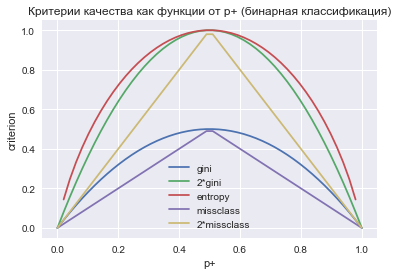

In [2]:
plt.rcParams['figure.figsize'] = (6,4)
xx = np.linspace(0,1,50)
plt.plot(xx, [2 * x * (1-x) for x in xx], label='gini')
plt.plot(xx, [4 * x * (1-x) for x in xx], label='2*gini')
plt.plot(xx, [-x * np.log2(x) - (1-x) * np.log2(1 - x)  for x in xx], label='entropy')
plt.plot(xx, [1 - max(x, 1-x) for x in xx], label='missclass')
plt.plot(xx, [2 - 2 * max(x, 1-x) for x in xx], label='2*missclass')
plt.xlabel('p+')
plt.ylabel('criterion')
plt.title('Критерии качества как функции от p+ (бинарная классификация)')
plt.legend();

#### Пример
Рассмотрим пример применения дерева решений из библиотеки Scikit-learn для синтетических данных. Сгенерируем данные. Два класса будут сгенерированы из двух нормальных распределений с разными средними.

In [3]:
# первый класс
np.seed = 7
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)

# добавляем второй класс
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]

Напишем вспомогательную функцию, которая будет возвращать решетку для дальнейшей красивой визуализации.

In [4]:
def get_grid(data, eps=0.01):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, eps),
                         np.arange(y_min, y_max, eps))

Отобразим данные. Неформально, задача классификации в этом случае – построить какую-то "хорошую" границу, разделяющую 2 класса (красные точки от желтых). Если утрировать, то машинное обучение в этом случае сводится к тому, как выбрать хорошую разделяющую границу. Возможно,  прямая будет слишком простой границей, а какая-то сложная кривая, огибающая каждую красную точку – будет слишком сложной и будем много ошибаться на новых примерах из того же распределения, из которого пришла обучающая выборка. Интуиция подсказывает, что хорошо на новых данных будет работать какая-то *гладкая* граница, разделяющая 2 класса, или хотя бы просто прямая (в $n$-мерном случае - гиперплоскость). 

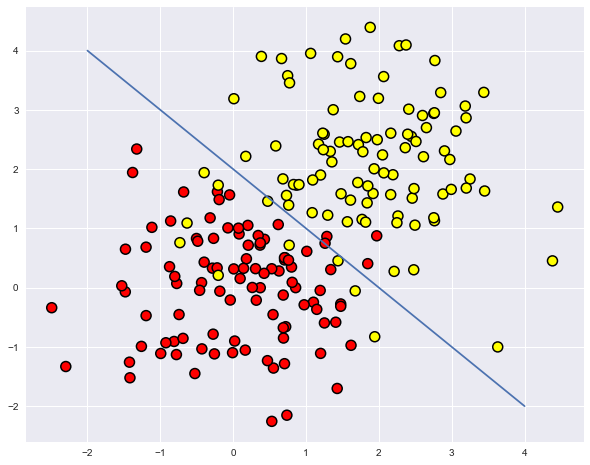

In [5]:
plt.rcParams['figure.figsize'] = (10,8)
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5)
plt.plot(range(-2,5), range(4,-3,-1));

Попробуем разделить эти два класса, обучив дерево решений. В дереве будем использовать параметр `max_depth`, ограничивающий глубину дерева. Визуализируем полученную границу разделения класссов.

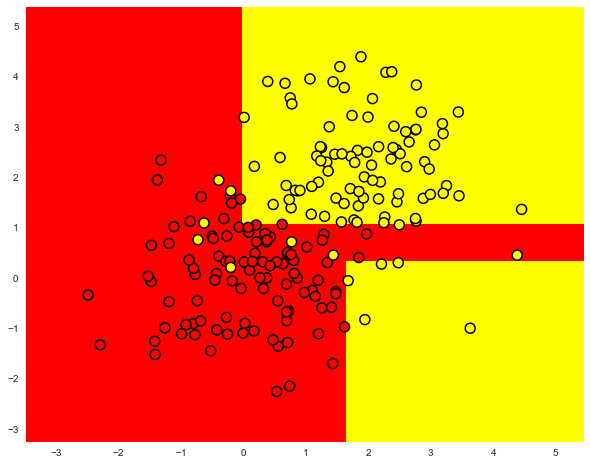

In [6]:
from sklearn.tree import DecisionTreeClassifier

# параметр min_samples_leaf указывает, при каком минимальном количестве
# элементов в узле он будет дальше разделяться
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=17)

# обучаем дерево
clf_tree.fit(train_data, train_labels)

# немного кода для отображения разделяющей поверхности
xx, yy = get_grid(train_data)
predicted = clf_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5);

А как выглядит само построенное дерево? Видим, что дерево "нарезает" пространство на 7 прямоугольников (в дереве 7 листьев). В каждом таком прямоугольнике прогноз дерева будет константным, по превалированию объектов того или иного класса.

In [7]:
# используем .dot формат для визуализации дерева
from sklearn.tree import export_graphviz
export_graphviz(clf_tree, feature_names=['x1', 'x2'], 
                out_file='../../img/small_tree.dot', filled=True)
!dot -Tpng '../../img/small_tree.dot' -o '../../img/small_tree.png'

<img src='../../img/small_tree.png'>

Как "читается" такое дерево?

В начале было 200 объектов, 100 - одного класса и 100 – другого. Энтропия начального состояния была максимальной – 1. Затем было сделано разбиение объектов на 2 группы в зависимости от сравнения признака $x_1$ со значением $0.3631$ (найдите этот участок границы на рисунке выше, до дерева). При этом энтропия и в левой, и в правой группе объектов уменьшилась. И так далее, дерево строится до глубины 3. При такой визуализации чем больше объектов одного класса, тем  цвет вершины ближе к темно-оранжевому и, наоборот, чем больше объектов второго класса, тем ближе цвет к темно-синему. В начале объектов одного лкасса поровну, поэтому корневая вершина дерева – белого цвета.

### Как дерево решений работает с количественными признаками

Допустим, в выборке имеется количественный признак "Возраст", имеющий много уникальных значений. Дерево решений будет искать лучшее (по критерию типа прироста информации) разбиение выборки, проверяя бинарные признаки типа "Возраст < 17", "Возраст < 22.87" и т.д. Но что если таких "нарезаний" возраста слишком много? А что если есть еще количественный признак "Зарплата", и зарплату тоже можно "нарезать" большим числом способов? Получается слишком много бинарных признаков для выбора лучшего на каждом шаге построения дерева. Для решения этой проблемы применяют эвристики для ограничения числа порогов, с которыми мы сравниваем количественный признак. 

Рассмотрим это на игрушечном примере. Пусть есть следующая выборка:

In [8]:
data = pd.DataFrame({'Возраст': [17,64,18,20,38,49,55,25,29,31,33], 
             'Невозврат кредита': [1,0,1,0,1,0,0,1,1,0,1]})

In [9]:
data

,Возраст,Невозврат кредита
0,17,1
1,64,0
2,18,1
3,20,0
4,38,1
5,49,0
6,55,0
7,25,1
8,29,1
9,31,0


Отсортируем ее по возрастанию возраста.

In [10]:
data.sort_values('Возраст')

,Возраст,Невозврат кредита
0,17,1
2,18,1
3,20,0
7,25,1
8,29,1
9,31,0
10,33,1
4,38,1
5,49,0
6,55,0


Обучим на этих данных дерево решений (без ограничения глубины) и посмотрим на него.

In [11]:
age_tree = DecisionTreeClassifier(random_state=17)
age_tree.fit(data['Возраст'].values.reshape(-1, 1), data['Невозврат кредита'].values)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best')

Видим, что дерево задействовало 5 значений, с которыми сравнивается возраст: 43.5, 19, 22.5, 30 и 32 года. Если приглядеться, то это аккурат средние значения между возрастами, при которых целевой класс "меняется" с 1 на 0 или наоборот. Сложная фраза, поэтому пример: 43.5 – это среднее между 38 и 49 годами, клиент, которому 38 лет не вернул кредит, а тот, которому 49 – вернул. Аналогично, 19 лет – среднее между 18 и 20 годами. То есть в качестве порогов для "нарезания" количественного признака, дерево "смотрит" на те значения, при которых целевой класс меняет свое значение. 

Подумайте, почему не имеет смысла в данном случае рассматривать признак "Возраст < 17.5".

In [12]:
export_graphviz(age_tree, feature_names=['Возраст'], 
                out_file='../../img/age_tree.dot', filled=True)
!dot -Tpng '../../img/age_tree.dot' -o '../../img/age_tree.png'

<img src='../../img/age_tree.png'>

Рассмотрим пример посложнее: добавим признак "Зарплата" (тыс. рублей/месяц).

In [13]:
data2 = pd.DataFrame({'Возраст':  [17,64,18,20,38,49,55,25,29,31,33], 
                      'Зарплата': [25,80,22,36,37,59,74,70,33,102,88], 
             'Невозврат кредита': [1,0,1,0,1,0,0,1,1,0,1]})

In [14]:
data2

,Возраст,Зарплата,Невозврат кредита
0,17,25,1
1,64,80,0
2,18,22,1
3,20,36,0
4,38,37,1
5,49,59,0
6,55,74,0
7,25,70,1
8,29,33,1
9,31,102,0


Если отсортировать по возрасту, то целевой класс ("Невозврат кредита") меняется (с 1 на 0 или наоборот) 5 раз. А если отсортировать по зарплате – то 7 раз. Как теперь дерево будет выбирать признаки? Посмотрим.

In [15]:
data2.sort_values('Возраст')

,Возраст,Зарплата,Невозврат кредита
0,17,25,1
2,18,22,1
3,20,36,0
7,25,70,1
8,29,33,1
9,31,102,0
10,33,88,1
4,38,37,1
5,49,59,0
6,55,74,0


In [16]:
data2.sort_values('Зарплата')

,Возраст,Зарплата,Невозврат кредита
2,18,22,1
0,17,25,1
8,29,33,1
3,20,36,0
4,38,37,1
5,49,59,0
7,25,70,1
6,55,74,0
1,64,80,0
10,33,88,1


In [17]:
age_sal_tree = DecisionTreeClassifier(random_state=17)
age_sal_tree.fit(data2[['Возраст', 'Зарплата']].values, data2['Невозврат кредита'].values);

In [18]:
export_graphviz(age_sal_tree, feature_names=['Возраст', 'Зарплата'], 
                out_file='../../img/age_sal_tree.dot', filled=True)
!dot -Tpng '../../img/age_sal_tree.dot' -o '../../img/age_sal_tree.png'

<img src='../../img/age_sal_tree.png'>

Видим, что в дереве задействованы как разбиения по возрасту, так и по зарплате. Причем пороги, с которыми сравниваются признаки: 43.5 и 22.5 года – для возраста и 95 и 30.5 тыс. руб/мес – для зарплаты. И опять можно заметить, что 95 тыс. – это среднее между 88 и 102, при этом человек с зарплатой 88 оказался "плохим", а с 102 – "хорошим". То же самое для 30.5 тыс. То есть перебирались сравнения зарплаты и возраста не со всеми возможными значениями, а только с несколькими. А почему в дереве оказались именно эти признаки? Потому что по ним разбиения оказались лучше (по критерию неопределенности Джини).  

**Вывод:** самая простая эвристика для обработки количественных признаков в дереве решений: количественный признак сортируется по возрастанию, и в дереве проверяются только те пороги, при которых целевой признак меняет значение. Звучит не очень строго, но надеюсь, я донес смысл с помощью игрушечных примеров.

Дополнительно, когда в данных много количественных признаков, и у каждого много уникальных значений, могут отбираться не все пороги, описанные выше, а только топ-N, дающих максимальный прирост все того же критерия. То есть, по сути, для каждого порога строится дерево глубины 1, считается насколько снизилась энтропия (или неопределенность Джини) и выбираются только лучшие пороги, с которыми стоит сравнивать количественный признак. 

Для иллюстрации: при разбиении по признаку "Зарплата $\leq$ 34.5" в левой подгруппе энтропия 0 (все клиенты "плохие"), а в правой – 0.954 (3 "плохих" и 5 "хороших", можете проверить, 1 часть домашнего задания будет как раз на то, чтоб разобраться досканально с построением деревьев). Прирост информации получается примерно 0.3.
А при разбиении по признаку "Зарплата $\leq$ 95" в левой подгруппе энтропия 0.97 (6 "плохих" и 4 "хороших"), а в правой – 0 (всего один объект). Прирост информации получается примерно 0.11.
Посчитав таким образом прирост информации для каждого разбиения, можно предварительно, до построения большого дерева (по всем признакам) отобрать пороги, с которыми будет сравниваться каждый количественный признак. 

Еще примеры дискретизации количественных признаков можно посмотреть в постах, подобных [этому](http://kevinmeurer.com/a-simple-guide-to-entropy-based-discretization/) или [этому](http://clear-lines.com/blog/post/Discretizing-a-continuous-variable-using-Entropy.aspx). Одна из самых известных научных статей на эту тему – "On the handling of continuous-valued attributes in decision tree generation" (U.M. Fayyad. K.B. Irani, "Machine Learning", 1992).

### Основные параметры дерева

В принципе дерево решений можно построить до такой глубины, чтоб в каждом листе был ровно один объект. Но на практике это не делается из-за того, что такое дерево будет *переобученным* – оно слишком настроится на обучающую выборку и будет плохо работать на прогноз на новых данных. Где-то внизу дерева, на большой глубине будут появляться разбиения по менее важным признакам (например, приехал ли клиент из Саратова или Костромы). Если утрировать, может оказаться так, что из всех 4 клиентов, пришедших в банк за кредитом в зеленых штанах, никто не вернул кредит. Но мы не хотим, чтобы наша модель классификации порождала такие специфичные правила. 

Основные способы борьбы с переобучением в случае деревьев решений:
 - искусственное ограничение глубины или минимального числа объектов в листе: построение дерева просто в какой-то момент прекращается;
 - стрижка дерева (*pruning*). При таком подходе дерево сначала строится до максимальной глубины, потом постепенно, снизу вверх, некоторые вершины дерева убираются за счет сравнения по качеству дерева с данным разбиением и без него (сравнение проводится с помощью *кросс-валидации*, о которой чуть ниже). Подробнее можно почитать в  материалах [репозитория](https://github.com/esokolov/ml-course-msu) Евгения Соколова.

### Класс DecisionTreeClassifier в Scikit-learn
Основные параметры класса [sklearn.tree.DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html):

- `max_depth` – максимальная глубина дерева
- `max_features` - максимальное число признаков, по которым ищется лучшее разбиение в дереве (это нужно потому, что при большом количестве признаков будет "дорого" искать лучшее (по критерию типа прироста информации) разбиение среди *всех* признаков)
- `min_samples_leaf` – минимальное число объектов в листе. У этого параметра есть понятная интерпретация: скажем, если он равен 5, то дерево будет порождать только те классифицирующие правила, которые верны как мимимум для 5 объектов

Параметры дерева надо настраивать в зависимости от входных данных, и делается это обычно с помощью *кросс-валидации*,  про нее чуть ниже.


## Дерево решений в задаче регрессии
 
 При прогнозировании количественного признака идея построения дерева остается та же, но меняется критерий качества: 
 
 - Дисперсия вокруг среднего: $$\Large D = \frac{1}{\ell} \sum\limits_{i =1}^{\ell} (y_i - \frac{1}{\ell} \sum\limits_{i =1}^{\ell} y_i)^2, $$
 где $\ell$ – число объектов в листе, $y_i$ – значения целевого признака. Попросту говоря, минимизируя дисперсию вокруг среднего, мы ищем признаки, разбивающие выборку таким образом, что значения целевого признака в каждом листе примерно равны.

#### Пример
Сгенерируем данные, распределенные вокруг функции $f(x) = e^{-x ^ 2} + 1.5 * e^{-(x - 2) ^ 2}$ c некоторым шумом.

In [19]:
n_train = 150        
n_test = 1000       
noise = 0.1


def f(x):
    x = x.ravel()

    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2) + \
        np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))

    return X, y

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

In [20]:
from sklearn.tree import DecisionTreeRegressor
     
reg_tree = DecisionTreeRegressor(max_depth=5, random_state=17)

reg_tree.fit(X_train, y_train)
reg_tree_pred = reg_tree.predict(X_test)

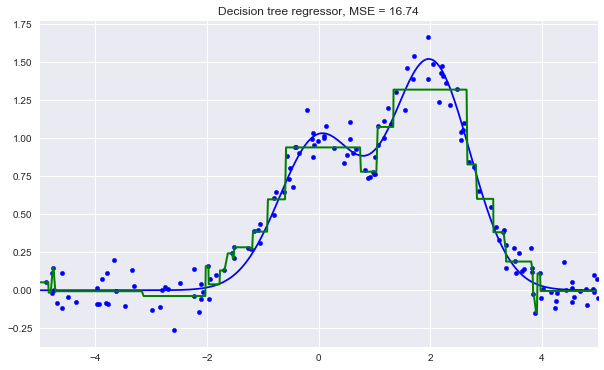

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, reg_tree_pred, "g", lw=2)
plt.xlim([-5, 5])
plt.title("Decision tree regressor, MSE = %.2f" % np.sum((y_test - reg_tree_pred) ** 2))
plt.show()

Видим, что дерево решений аппроксимирует зависимость в данных кусочно-постоянной функцией. 

# Метод ближайших соседей

Метод ближайших соседей (k Nearest Neighbors, или kNN) — тоже очень популярный метод классификации, также иногда используемый в задачах регрессии. Это, наравне с деревом решений, один из самых понятных подходов к классификации. На уровне интуиции суть метода такова: посмотри на соседей, какие преобладают, таков и ты. Формально основой метода является гипотезой компактности: если метрика расстояния между примерами введена достаточно удачно, то схожие примеры гораздо чаще лежат в одном классе, чем в разных. 

Согласно методу ближайших соседей, тестовый пример (зеленый шарик) будет отнесен к классу "синие", а не "красные".

<img src="../../img/kNN.png">

Например, если не знаешь, какой тип товара указать в объявлении для Bluetooth-гарнитуры, можешь найти 5 похожих гарнитур, и если 4 из них отнесены к категории "Аксессуары", и только один - к категории "Техника", то здравый смысл подскажет для своего объявления тоже указать категорию "Аксессуары".

Для классификации каждого из объектов тестовой выборки необходимо последовательно выполнить следующие операции:
 - Вычислить расстояние до каждого из объектов обучающей выборки
 - Отобрать $k$ объектов обучающей выборки, расстояние до которых минимально
 - Класс классифицируемого объекта — это класс, наиболее часто встречающийся среди $k$ ближайших соседей
 
 Примечательное свойство такого подхода  – его ленивость. Это значит, что вычисления начинаются только в момент классификации тестового примера, а заранее, только при  наличии обучающих примеров, никакая модель не строится. В этом отличие, например, от ранее рассмотренного дерева решений, где сначала на основе обучающей выборки строится дерево, а потом относительно быстро происходит классификация тестовых примеров. 
 
Стоит отметить, что метод ближайших соседей – хорошо изученный подход (в машинном обучении, эконометрике и статистике больше известно наверно только про линейную регрессию). Для метода ближайших соседей существует немало важных теорем, утверждающих, что на "бесконечных" выборках это оптимальный метод классификации. Авторы классической книги "The Elements of Statistical Learning" считают kNN теоретически идеальным алгоритмом, применимость которого просто ограничена вычислительными возможностями и проклятием размерностей. 

### Метод ближайших соседей в реальных задачах
- В чистом виде kNN может послужить хорошим стартом (baseline) в решении какой-либо задачи;
- В соревнованиях Kaggle kNN часто используется для построения мета-признаков (прогноз kNN подается на вход прочим моделям) или в стекинге/блендинге;
- Идея ближайшего соседа расширяется и на другие задачи, например, в рекомендательных системах простым начальным решением может быть рекомендация какого-то товара (или услуги), популярного среди *ближайших соседей* человека, которому хотим сделать рекомендацию;
- На практике для больших выборок часто пользуются *приближенными* методами поиска ближайших соседей. [Вот](https://www.youtube.com/watch?v=UUm4MOyVTnE) лекция Артема Бабенко про эффективные алгоритмы поиска ближайших соседей среди миллиардов объектов в пространствах высокой размерности (поиск по картинкам). Также известны открытые библиотеки, в которых реализованы такие алгоритмы, спасибо компании Spotify за ее библиотеку [Annoy](https://github.com/spotify/annoy).

Качество классификации методом ближайших соседей зависит от нескольких параметров:
 - число соседей
 - метрика расстояния между объектами (часто используются метрика Хэмминга, евклидово расстояние, косинусное расстояние и расстояние Минковского). Отметим, что при использовании большинства метрик значения признаков надо масштабировать. Условно говоря, чтобы признак "Зарплата" с диапазоном значений до 100 тысяч не вносил больший вклад в расстояние, чем "Возраст" со значениями до 100. 
 - веса соседей (соседи тестового примера могут входить с разными весами, например, чем дальше пример, тем с меньшим коэффициентом учитывается его "голос")

 
### Класс KNeighborsClassifier в Scikit-learn
Основные параметры класса sklearn.neighbors.KNeighborsClassifier:
 - weights: "uniform" (все веса равны), "distance" (вес обратно пропорционален расстоянию до тестового примера) или другая определенная пользователем функция
 - algorithm (опционально): "brute", "ball_tree", "KD_tree", или "auto". В первом случае ближайшие соседи для каждого тестового примера считаются перебором обучающей выборки. Во втором и третьем - расстояние между примерами хранятся в дереве, что ускоряет нахождение ближайших соседей. В случае указания параметра "auto" подходящий способ нахождения соседей будет выбран автматически на основе обучающей выборки.
 - leaf_size (опционально): порог переключения на полный перебор в случае выбора BallTree или KDTree для нахождения соседей
 - metric: "minkowski", "manhattan", "euclidean", "chebyshev" и другие

# Выбор параметров модели и кросс-валидация 

Главная задача обучаемых алгоритмов – их способность *обобщаться*, то есть хорошо работать на новых данных. Поскольку, на новых данных мы сразу не можем проверить качество построенной модели (нам ведь надо для них сделать прогноз, то есть истинных значений целевого признака мы для них не знаем), то надо пожертвовать небольшой порцией данных, чтоб на ней проверить качество модели. 

Чаще всего это делается одним из 2 способов:

 - отложенная выборка (*held-out/hold-out set*). При таком подходе мы оставляем какую-то долю обучающей выборки (как правило от 20% до 40%), обучаем модель на остальных данных (60-80% исходной выборки) и считаем некоторую метрику качества модели (например, самое простое – долю правильных ответов в задаче классификации) на отложенной выборке. 
 - кросс-валидация (*cross-validation*, на русский еще переводят как скользящий или перекрестный контроль). Тут самый частый случай – K-fold кросс-валидация
 <img src='../../img/cross_validation.png'><br>
 
Тут модель обучается K раз на разных (K-1) подвыборках исходной выборки (белый цвет), а проверяется на одной подвыборке (каждый раз на разной, оранжевый цвет). 
Получаются $K$ оценок качества модели, которые обычно усредняются, выдавая среднюю оценку качества классификации/регресии на кросс-валидации.

Кросс-валидация дает лучшую по сравнению отложенной выборкой оценку качества модели на новых данных. Но кросс-валидация вычислительно дорогостоящая, если данных много. 

Кросс-валидация – очень важная техника в машинном обучении (применяемая также в статистике и эконометрике), с ее помощью выбираются гиперпараметры моделей, сравниваются модели между собой, оценивается полезность новых признаков в задаче и т.д. Более подробно можно почитать, например, [тут](https://sebastianraschka.com/blog/2016/model-evaluation-selection-part1.html) у Sebastian Raschka или в любом классическом учебнике по машинному (статистическому) обучению

## Деревья решений и метод ближайших соседей в задаче прогнозирования оттока клиентов телеком-оператора

Считаем данные в DataFrame и проведем предобработку. Штаты пока сохраним в отдельный объект Series, но удалим из датафрейма. Первую модель будем обучать без штатов, потом посмотрим, помогают ли они. 

In [22]:
df = pd.read_csv('../../data/telecom_churn.csv')

In [23]:
df['International plan'] = pd.factorize(df['International plan'])[0]
df['Voice mail plan'] = pd.factorize(df['Voice mail plan'])[0]
df['Churn'] = df['Churn'].astype('int')
states = df['State']
y = df['Churn']
df.drop(['State', 'Churn'], axis=1, inplace=True)

In [24]:
df.head()

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,128,415,0,0,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,107,415,0,0,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,137,415,0,1,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,84,408,1,1,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,75,415,1,1,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


In [25]:
from sklearn.model_selection import train_test_split, StratifiedKFold

Выделим 70% выборки (X_train, y_train) под обучение и 30% будут отложенной выборкой (X_holdout, y_holdout). отложенная выборка никак не будет участвовать в настройке параметров моделей, на ней мы в конце, после этой настройки, оценим качество полученной модели.

In [26]:
X_train, X_holdout, y_train, y_holdout = train_test_split(df.values, y, test_size=0.3,
                                                          random_state=17)

Обучим 2 модели – дерево решений и kNN, пока не знаем, какие параметры хороши, поэтому наугад: глубину дерева берем 5, число ближайших соседей – 10.

In [27]:
from sklearn.neighbors import KNeighborsClassifier

tree = DecisionTreeClassifier(max_depth=5, random_state=17)
knn = KNeighborsClassifier(n_neighbors=10)

In [28]:
%%time
tree.fit(X_train, y_train)

CPU times: user 11.7 ms, sys: 998 µs, total: 12.7 ms
Wall time: 11.7 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best')

In [29]:
%%time
knn.fit(X_train, y_train)

CPU times: user 2.82 ms, sys: 1.59 ms, total: 4.41 ms
Wall time: 4.76 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

Качество прогнозов будем проверять с помощью простой метрики – доли правильных ответов

In [30]:
from sklearn.metrics import accuracy_score

Сделаем прогнозы для отложенной выборки. Видим, что метод ближайших соседей справился намного лучше. Но это мы пока выбирали параметры наугад. 

In [31]:
tree_pred = tree.predict(X_holdout)
accuracy_score(y_holdout, tree_pred)

0.93999999999999995

In [32]:
knn_pred = knn.predict(X_holdout)
accuracy_score(y_holdout, knn_pred)

0.88100000000000001

Теперь настроим параметры дерева на кросс-валидации. Настраивать будем максимальную глубину и максимальное используемое на каждом разбиении число признаков. Суть того, как работает GridSearchCV: для каждой уникальной пары значений  параметров `max_depth` и `max_features` будет проведена 5-кратная кросс-валидация и выберется лучшее сочетание параметров.

In [33]:
from sklearn.model_selection import GridSearchCV, cross_val_score

In [34]:
tree_params = {'max_depth': range(1,11),
               'max_features': range(4,19)}

In [35]:
tree_grid = GridSearchCV(tree, tree_params,
                         cv=5, n_jobs=-1,
                        verbose=True)

In [36]:
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Done 296 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    1.8s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(1, 11), 'max_features': range(4, 19)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

Лучшее сочетание параметров и соответствующая средняя доля правильных ответов на кросс-валидации:

In [37]:
tree_grid.best_params_

{'max_depth': 6, 'max_features': 17}

In [38]:
tree_grid.best_score_

0.94256322331761677

In [39]:
accuracy_score(y_holdout, tree_grid.predict(X_holdout))

0.94599999999999995

Теперь попробуем настроить число соседей в алгоритме kNN.

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [41]:
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1))])

In [42]:
knn_params = {'knn__n_neighbors': range(1, 10)}

In [43]:
knn_grid = GridSearchCV(knn_pipe, knn_params,
                         cv=5, n_jobs=-1,
                        verbose=True)

In [44]:
knn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.0s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'knn__n_neighbors': range(1, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

In [45]:
knn_grid.best_params_, knn_grid.best_score_

({'knn__n_neighbors': 7}, 0.88598371195885128)

In [46]:
accuracy_score(y_holdout, knn_grid.predict(X_holdout))

0.89000000000000001

Видим, что в этом примере дерево показало себя лучше, чем метод ближайших соседей. Более того, в данной задаче дерево проявляет себя очень хорошо, и даже случайный лес (который пока представляем просто как кучу деревьев, которые вместе работают почему-то намного лучше, чем одно дерево) в этом примере показывает долю правильных ответов не намного выше (как на кросс-валидации, так и на отложенной выборке), а обучается намного дольше. 

In [47]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=17)
print(np.mean(cross_val_score(forest, X_train, y_train, cv=5)))

0.949423311981


In [48]:
forest_params = {'max_depth': range(1,11),
               'max_features': range(4,19)}

In [49]:
forest_grid = GridSearchCV(forest, forest_params,
                         cv=5, n_jobs=-1,
                         verbose=True)

In [50]:
forest_grid.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:  1.7min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=17,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(1, 11), 'max_features': range(4, 19)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

In [51]:
forest_grid.best_params_, forest_grid.best_score_

({'max_depth': 9, 'max_features': 6}, 0.95113587655379339)

In [52]:
accuracy_score(y_holdout, forest_grid.predict(X_holdout))

0.95299999999999996

Нарисуем получившееся дерево. Из-за того, что оно не совсем игрушечное (максимальная глубина – 6), картинка получается уже не маленькой, но по дерево можно "прогуляться", если отдельно открыть рисунок.

In [53]:
export_graphviz(tree_grid.best_estimator_, feature_names=df.columns, 
                out_file='../../img/churn_tree.dot', filled=True)
!dot -Tpng '../../img/churn_tree.dot' -o '../../img/churn_tree.png'

<img src='../../img/churn_tree.png'>

## Деревья решений и метод ближайших соседей в задаче распознавания рукописных цифр MNIST

Теперь посмотрим на описанные 2 алгоритма в реальной задаче. Используемый "встроенные" в `sklearn` данные по рукописным цифрам. Эта задача будет примером, когда метод ближайших соседей работает на удивление хорошо.

In [54]:
from sklearn.datasets import load_digits

Загружаем данные.

In [55]:
data = load_digits()
X, y = data.data, data.target

Картинки здесь представляются матрицей 8 x 8 (интенсивности белого цвета для каждого пикселя). Далее эта матрица "разворачивается" в вектор длины 64, получается признаковое описание объекта.

In [56]:
X[0,:].reshape([8,8])

array([[  0.,   0.,   5.,  13.,   9.,   1.,   0.,   0.],
       [  0.,   0.,  13.,  15.,  10.,  15.,   5.,   0.],
       [  0.,   3.,  15.,   2.,   0.,  11.,   8.,   0.],
       [  0.,   4.,  12.,   0.,   0.,   8.,   8.,   0.],
       [  0.,   5.,   8.,   0.,   0.,   9.,   8.,   0.],
       [  0.,   4.,  11.,   0.,   1.,  12.,   7.,   0.],
       [  0.,   2.,  14.,   5.,  10.,  12.,   0.,   0.],
       [  0.,   0.,   6.,  13.,  10.,   0.,   0.,   0.]])

Нарисуем несколько рукописных цифр, видим, что они угадываются.

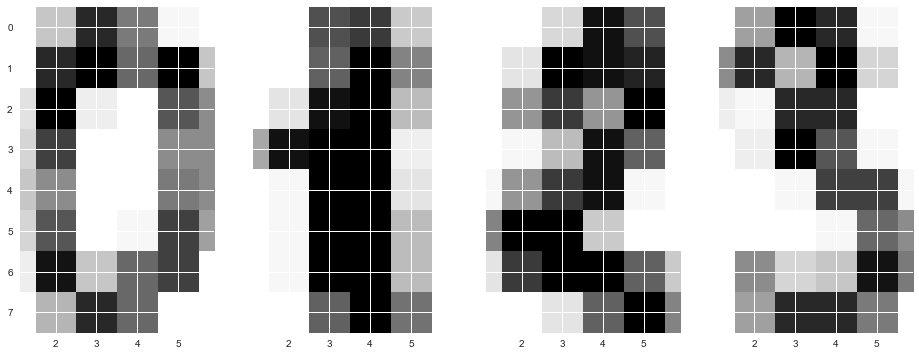

In [57]:
f, axes = plt.subplots(1, 4, sharey=True, figsize=(16,6))
for i in range(4):
    axes[i].imshow(X[i,:].reshape([8,8]));


Посмотрим на соотношение классов в выборке, видим, что примерно поровну нулей, единиц, ..., девяток.

In [58]:
np.bincount(y)

array([178, 182, 177, 183, 181, 182, 181, 179, 174, 180])

Выделим 70% выборки (X_train, y_train) под обучение и 30% будут отложенной выборкой (X_holdout, y_holdout). отложенная выборка никак не будет участвовать в настройке параметров моделей, на ней мы в конце, после этой настройки, оценим качество полученной модели.

In [59]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3,
                                                          random_state=17)

Обучим дерево решений и kNN, опять параметры пока наугад берем.

In [60]:
tree = DecisionTreeClassifier(max_depth=5, random_state=17)
knn = KNeighborsClassifier(n_neighbors=10)

In [61]:
%%time
tree.fit(X_train, y_train)

CPU times: user 9.21 ms, sys: 1.23 ms, total: 10.4 ms
Wall time: 9.45 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best')

In [62]:
%%time
knn.fit(X_train, y_train)

CPU times: user 3.13 ms, sys: 1.19 ms, total: 4.32 ms
Wall time: 3.24 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

Сделаем прогнозы для отложенной выборки. Видим, что метод ближайших соседей справился намного лучше. Но это мы пока выбирали параметры наугад. 

In [63]:
tree_pred = tree.predict(X_holdout)
knn_pred = knn.predict(X_holdout)
accuracy_score(y_holdout, knn_pred), accuracy_score(y_holdout, tree_pred)

(0.97407407407407409, 0.66666666666666663)

Теперь так же, как раньше настроим параметры моделей на кросс-валидации, только учтем, что признаков сейчас больше, чем в прошлой задаче - 64. 

In [64]:
tree_params = {'max_depth': [1, 2, 3, 5, 10, 20, 25, 30, 40, 50, 64],
               'max_features': [1, 2, 3, 5, 10, 20 ,30, 50, 64]}

In [65]:
tree_grid = GridSearchCV(tree, tree_params,
                         cv=5, n_jobs=-1,
                        verbose=True)

In [66]:
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits


[Parallel(n_jobs=-1)]: Done 495 out of 495 | elapsed:    0.8s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [1, 2, 3, 5, 10, 20, 25, 30, 40, 50, 64], 'max_features': [1, 2, 3, 5, 10, 20, 30, 50, 64]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

Лучшее сочетание параметров и соответствующая средняя доля правильных ответов на кросс-валидации:

In [67]:
tree_grid.best_params_, tree_grid.best_score_

({'max_depth': 20, 'max_features': 64}, 0.84407319013524262)

In [68]:
accuracy_score(y_holdout, tree_grid.predict(X_holdout))

0.83888888888888891

Это уже не 66%, но и не 97%. Метод ближайших соседей на этом наборе данных работает лучше. В случае одного ближайшего соседа на кросс-валидации достигается почти 99% угадываний.

In [69]:
np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=1), X_train, y_train, cv=5))

0.98654584223971487

In [70]:
knn = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
accuracy_score(y_holdout, knn.predict(X_holdout))

0.98333333333333328

Обучим на этих же данных случайный лес, он на большинстве выборок работает лучше, чем метод ближайших соседей. Но сейчас у нас исключение. 

In [71]:
np.mean(cross_val_score(RandomForestClassifier(random_state=17), X_train, y_train, cv=5))

0.93490856191104044

In [72]:
rf = RandomForestClassifier(random_state=17, n_jobs=-1).fit(X_train, y_train)
accuracy_score(y_holdout, rf.predict(X_holdout))

0.94074074074074077

Вы будете правы, если возразите, что мы тут не настраивали параметры RandomForestClassifier, но даже с настройкой доля правильных ответов не достигает 98%, как для у метода одного ближайшего соседа. 

Результаты эксперимента:

|     |   CV  | Holdout |  
|-----|:-----:|:-------:|
| **DT**  | 0.844 |  0.838  |  
| **kNN** | 0.987 |  0.983  |
| **RF**  | 0.935 |  0.941  | 

Обозначения: CV и Holdout– средние доли правильных ответов модели на кросс-валидации и отложенной выборке соот-но. DT – дерево решений, kNN – метод ближайших соседей, RF – случайный лес


**Вывод** по этому эксперименту (и общий совет): в начале проверяйте на своих данных простые модели – дерево решений и метод ближайших соседей (а в следующий раз сюда добавится логистическая регрессия), может оказаться, что уже они работают достаточно хорошо. 

## Плюсы и минусы деревьев решений

**Плюсы:**
 - Порождение четких правил классификации, понятных человеку, например, "если возраст < 25 и интерес к мотоциклам, то отказать в кредите". Это свойство называют интерпретируемостью модели;
 - Деревья решений могут легко визуализироваться, то есть может "интерпретироваться" (строгого определения я не видел) как сама модель (дерево), так и прогноз для отдельного взятого тестового объекта (путь в дереве);
 - Быстрые процессы обучения и прогнозирования;
 - Малое число параметров модели;
 - Поддержка и числовых, и категориальных признаков.
 
**Минусы:**
 - У порождения четких правил классификации есть и другая сторона: деревья очень чувствительны к шумам во входных данных, вся модель может кардинально измениться, если немного изменится обучающая выборка (например, если убрать один из признаков или добавить несколько объектов), поэтому и правила классификации могут сильно изменяться, что ухудшает интерпретируемость модели;
 - Разделяющая граница, построенная деревом решений, имеет свои ограничения (состоит из гиперплоскостей, перпендикулярных какой-то из координатной оси), и на практике дерево решений по качеству классификации уступает некоторым другим методам;
 - Необходимость отсекать ветви дерева (pruning) или устанавливать минимальное число элементов в листьях дерева или максимальную глубину дерева для борьбы с переобучением. Впрочем, переобучение - проблема всех методов машинного обучения;
 - Нестабильность. Небольшие изменения в данных могут существенно изменять построенное дерево решений. С этой проблемой борются с помощью ансамблей деревьев решений (рассмотрим далее);
 - Проблема поиска оптимального дерева решений (минимального по размеру и способного без ошибок классифицировать выборку) NP-полна, поэтому на практике используются эвристики типа жадного поиска признака с максимальным приростом информации, которые не гарантируют нахождения глобально оптимального дерева;
 - Сложно поддерживаются пропуски в данных. Friedman оценил, что на поддержку пропусков в данных ушло около 50% кода CART (классический алгоритм построения деревьев классификации и регрессии – Classification And Regression Trees, в `sklearn` реализована улучшенная версия именно этого алгоритма);
 - Модель умеет только интерполировать, но не  экстраполировать (это же верно и для леса и бустинга на деревьях). То есть дерево решений делает константный прогноз для объектов, находящихся в признаковом пространстве вне параллелепипеда, охватывающего все объекты обучающей выборки. В нашем примере с желтыми и синими шариками это значит, что модель дает одинаковый прогноз для всех шариков с координатой > 19 или < 0.

### Плюсы и минусы метода ближайших соседей

Плюсы:
 - Простая реализация
 - Можно адаптировать под нужную задачу выбором метрики или ядра (в двух словах: ядро может задавать операцию сходства для сложных объектов типа графов, а сам подход kNN остается тем же). Кстати, профессор ВМК МГУ и опытный участник соревнований по анализу данных Александр Дьяконов любит самый простой kNN, но с настроенной метрикой сходства объектов. Можно почитать про некоторые его решения (в частности, "VideoLectures.Net Recommender System Challenge") на персональном [сайте](http://alexanderdyakonov.narod.ru/contests.htm);
 - Неплохая интерпретация, можно объяснить, почему тестовый пример был классифицирован именно так. Хотя этот аргумент можно атаковать: если число соседей большое, то интерпретация ухудшается (условно: "мы не дали ему кредит, потому что он похож на 350 клиентов, из которых 70 – плохие, что на 12% больше, чем в среднем по выборке").
 
Минусы:
 - Метод считается быстрым в сравнении, например, с композициями алгоритмов, но в реальных задачах, как правило, число соседей, используемых для классификации, будет большим (100-150), и в таком случае алгоритм будет работать не так быстро, как дерево решений;
 - Если в наборе данных много признаков, то трудно подобрать подходящие веса и определить, какие признаки не важны для классификации/регрессии;
 - Зависимость от выбранной метрики расстояния между примерами. Выбор по умолчанию евклидового расстояния чаще всего ничем не обоснован. Можно отыскать хорошее решение перебором параметров, но для большого набора данных это отнимает много времени;
 - Нет теоретических оснований выбора определенного числа соседей - только перебор (впрочем, чаще всего это верно для всех гиперпараметров всех моделей). В случае малого числа соседей метод чувствителен к выбросам, то есть склонен переобучаться;
 - Как правило, плохо работает, когда признаков много, из-за "прояклятия размерности". Про это хорошо рассказывает известный в ML-сообществе профессор Pedro Domingos – [тут](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf) в популярной статье "A Few Useful Things to Know about Machine Learning", также "the curse of dimensionality" описывается в книге Deep Learning в [главе](http://www.deeplearningbook.org/contents/ml.html) "Machine Learning basics".

### Сложный случай для деревьев
В продолжение обсуждения плюсов и минусов приведем очень простой пример задачи классификации, с которым дерево справляется, но делает все как-то "сложнее", чем хотелось бы. Создадим множество точек на плоскости (2 признака), каждая точка будет относиться к одному из классов (+1, красные, или -1 – желтые). Если смотреть на это как на задачу классификации, то вроде все очень просто – классы разделяются прямой. 

In [73]:
def form_linearly_separable_data(n=500, x1_min=0, x1_max=30, x2_min=0, x2_max=30):
    data, target = [], []
    for i in range(n):
        x1, x2 = np.random.randint(x1_min, x1_max), np.random.randint(x2_min, x2_max)
        
        if np.abs(x1 - x2) > 0.5:
            data.append([x1, x2])
            target.append(np.sign(x1 - x2))
    return np.array(data), np.array(target)

In [74]:
X, y = form_linearly_separable_data()

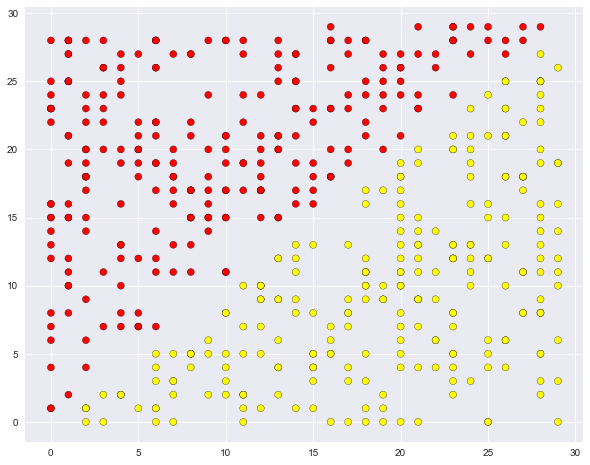

In [75]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolors='black');

Однако дерево решений строит уж больно сложную границу и само по себе оказывается глубоким. Кроме того, представьте, как плохо дерево будет обобщаться на пространство вне представленного квадрата $30 \times 30$, обрамляющего обучающую выборку.

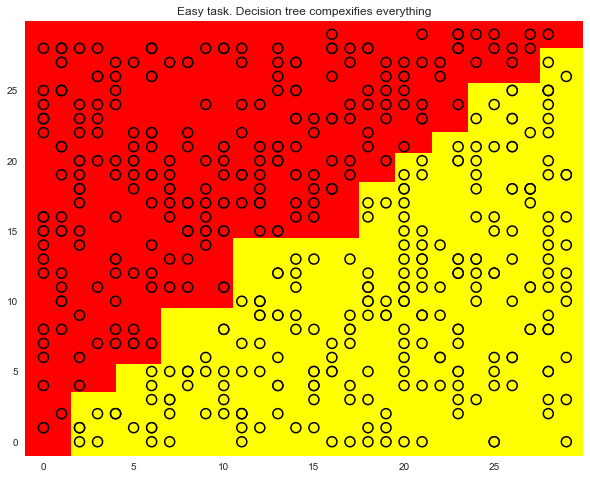

In [76]:
tree = DecisionTreeClassifier(random_state=17).fit(X, y)

xx, yy = get_grid(X, eps=.05)
predicted = tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(X[:, 0], X[:, 1], c=y, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5)
plt.title('Easy task. Decision tree compexifies everything');

Вот такая сложная конструкция, хотя решение (хорошая разделяющая поверхность) – это всего лишь прямая $x_1 = x_2$.

In [77]:
export_graphviz(tree, feature_names=['x1', 'x2'], 
                out_file='../../img/deep_toy_tree.dot', filled=True)
!dot -Tpng '../../img/deep_toy_tree.dot' -o '../../img/deep_toy_tree.png'

<img src='../../img/deep_toy_tree.png'>

Метод одного ближайшего соседа здесь справляется вроде лучше дерева, но все же не так хорошо, как линейный классификатор (наша следующая тема).

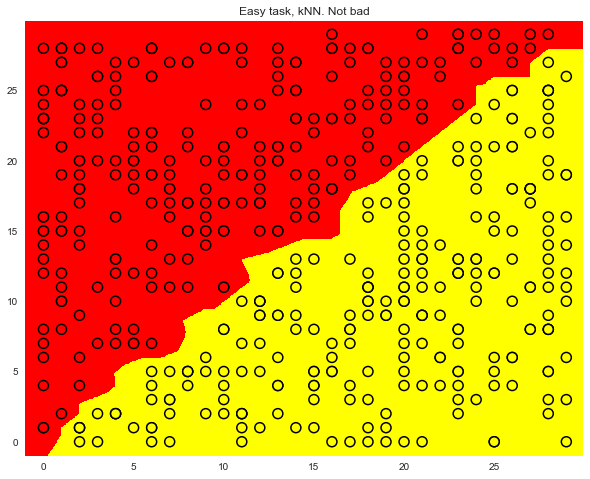

In [78]:
knn = KNeighborsClassifier(n_neighbors=1).fit(X, y)

xx, yy = get_grid(X, eps=.05)
predicted = knn.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(X[:, 0], X[:, 1], c=y, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5);
plt.title('Easy task, kNN. Not bad');

### Сложный случай для метода ближайших соседей
Теперь рассмотрим еще один простой пример. В задаче классификации один из признаков будет просто пропорционален вектору ответов, но методу ближайших соседей это не поможет.

In [79]:
def form_noisy_data(n_obj=1000, n_feat=100, random_seed=17):
    np.seed = random_seed
    y = np.random.choice([-1, 1], size=n_obj)
    
    # первый признак пропорционален целевому
    x1 = 0.3 * y
    
    # остальные признаки – шум
    
    x_other = np.random.random(size=[n_obj, n_feat - 1])
    
    return np.hstack([x1.reshape([n_obj, 1]), x_other]), y

In [80]:
X, y = form_noisy_data()

Как обычно, будем смотреть на долю правильных ответов на кросс-валидации и на отложенной выборке. Построим кривые, отражающие зависимость этих величин от параметра `n_neighbors` в методе ближайших соседей. Такие кривые называются кривыми валидации.

In [81]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3,
                                                          random_state=17)

Видим, что метод ближайших соседей с евклидовой метрикой не справляется с задачей, даже если варьировать число ближайших соседей в широком диапазоне. Напротив, дерево решений легко "обнаруживает" скрытую зависимость в данных при любом ограничении на максимальную глубину.

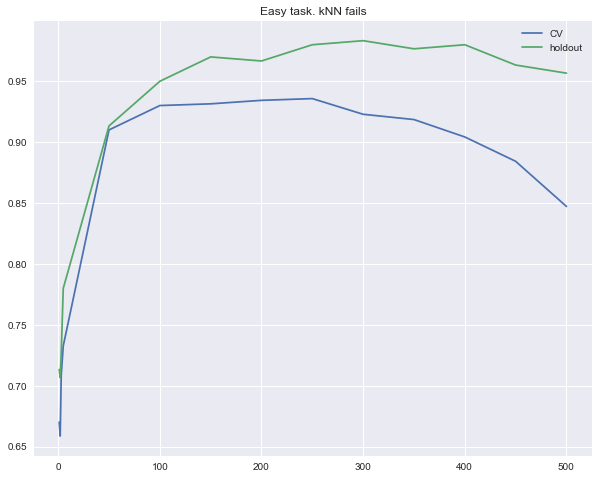

In [82]:
from sklearn.model_selection import cross_val_score

cv_scores, holdout_scores = [], []
n_neighb = [1, 2, 3, 5] + list(range(50, 550, 50))

for k in n_neighb:

    knn = KNeighborsClassifier(n_neighbors=k)
    cv_scores.append(np.mean(cross_val_score(knn, X_train, y_train, cv=5)))
    knn.fit(X_train, y_train)
    holdout_scores.append(accuracy_score(y_holdout, knn.predict(X_holdout)))

plt.plot(n_neighb, cv_scores, label='CV')
plt.plot(n_neighb, holdout_scores, label='holdout')
plt.title('Easy task. kNN fails')
plt.legend();

In [83]:
tree = DecisionTreeClassifier(random_state=17, max_depth=1)
tree_cv_score = np.mean(cross_val_score(tree, X_train, y_train, cv=5))
tree.fit(X_train, y_train)
tree_holdout_score = accuracy_score(y_holdout, tree.predict(X_holdout))
print('Decision tree. CV: {}, holdout: {}'.format(tree_cv_score, tree_holdout_score))

Decision tree. CV: 1.0, holdout: 1.0


Итак, во втором примере дерево справилось с задачей идеально, а метод ближайших соседей испытал трудности. Впрочем, это минус скорее не метода, а используемой евклидовой метрики: в данном случае она не позволила выявить, что один признак намного лучше остальных. 